<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [ ]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

In [1]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

## Задание 1 (1 балл). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекомендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



Источники данных:

1.   Величина импорта нефти - месячная частота данных. https://github.com/rishabh89007/Time_Series_Datasets/blob/main/Imports%20Crude%20Oil.csv
2.   Показатели климата в Дели - ежедневная частота данных. https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data?select=DailyDelhiClimateTrain.csv Тут несколько переменных. В качестве переменной для временного ряда взяла среднюю температуру воздуха.

Данные в ноутбук будем загружать из github. Для второго временного ряда загрузила в гитхаб, чтобы было удобнее воспроизводить. 



In [2]:
url_ts1 = 'https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/Imports%20Crude%20Oil.csv'
url_ts2 = 'https://raw.githubusercontent.com/akgubina/iadhw/main/DailyDelhiClimateTrain.csv'

ts1 = pd.read_csv(url_ts1, index_col=0, parse_dates=[0])
ts2 = pd.read_csv(url_ts2, index_col=0, parse_dates=[0])

**Данные с месячной частотой - величина импорта нефти**

In [3]:
ts1 = ts1.reset_index(level=0)
ts1 = ts1.rename(columns={'index':'date', 
                          'Imports of all grades of crude oil from World to Total U.S. (US), Monthly (thousand barrels)': 'oil_imports'})
# перевела в float, чтобы все модели смогли прочитать данные
ts1['oil_imports'] = pd.to_numeric(ts1['oil_imports']).astype(float) 

,date,oil_imports
0,2009-01-01,317275.0
1,2009-02-01,262339.0
2,2009-03-01,303897.0
3,2009-04-01,285934.0
4,2009-05-01,281147.0
...,...,...
140,2020-09-01,161926.0
141,2020-10-01,164494.0
142,2020-11-01,168655.0
143,2020-12-01,178597.0


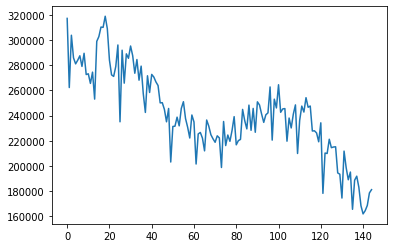

In [4]:
plt.plot(ts1['oil_imports'])

Нарисовала график, чтобы прикинуть, в какой пропорции разделить на трейн и тест. Здесь в целом не особо видно сезонности, наблюдения по месяцам, временной горизонт 12 лет. Решила разделить 80/20.

**Данные с дневной частотой - средняя температура воздуха в Дели**

In [5]:
ts2 = ts2.reset_index(level=0)
ts2 = ts2[['date', 'meantemp']]

ts2

,date,meantemp
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000
...,...,...
1457,2016-12-28,17.217391
1458,2016-12-29,15.238095
1459,2016-12-30,14.095238
1460,2016-12-31,15.052632


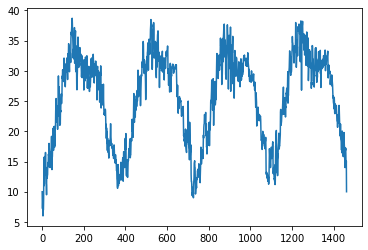

In [6]:
plt.plot(ts2['meantemp'])

Здесь хорошо видна сезонность. Решила разделить 3:1, как будто мы имитируем ситуацию, в которой у нас есть данные для трех лет и мы хотим предсказать значения на год вперед для четвертого года.

In [7]:
# сделаем разбиение на train/test

# границу разделения в отдельную переменную - потом пригодится для графиков
breakpoint_ts1 = int(len(ts1)*0.8) # 116
ts1_train = ts1[:breakpoint_ts1] 
ts1_test = ts1[breakpoint_ts1:]
assert len(ts1_train) + len(ts1_test) == len(ts1)

breakpoint_ts2 = int(len(ts2)*0.75) # 1096
ts2_train = ts2[:breakpoint_ts2] 
ts2_test = ts2[breakpoint_ts2:]
assert len(ts2_train) + len(ts2_test) == len(ts2)

## Задание 2. Анализ временных рядов (1 балл).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики [автокорреляционных функций](https://www.machinelearningmastery.ru/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788/) для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

**Графики рядов**

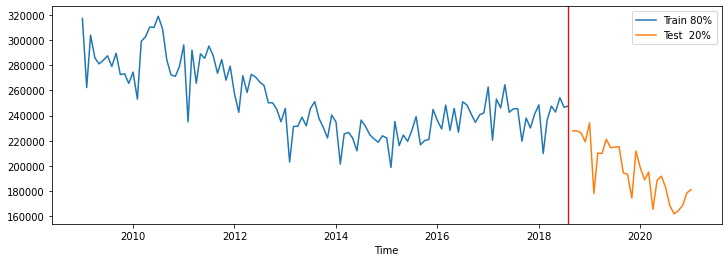

In [10]:
# отрисуем временные ряды
plt.figure(figsize=(12, 4))

plt.plot(ts1_train['date'], ts1_train['oil_imports'], label = 'Train 80%')
plt.plot(ts1_test['date'], ts1_test['oil_imports'], label = 'Test  20%')
plt.axvline(x=ts1['date'][breakpoint_ts1-1], linestyle='-', color='red',  linewidth=1.3)

plt.legend()
plt.xlabel('Time')
plt.show()

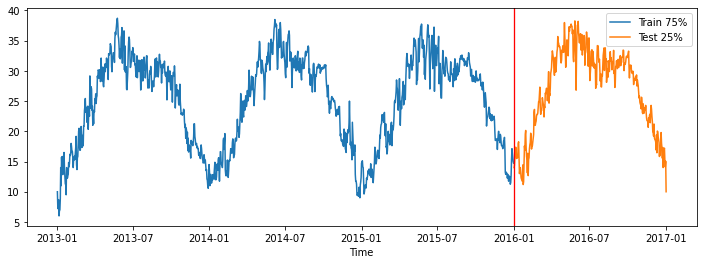

In [11]:
# отрисуем временные ряды
plt.figure(figsize=(12, 4))

plt.plot(ts2_train['date'], ts2_train['meantemp'], label = 'Train 75%')
plt.plot(ts2_test['date'], ts2_test['meantemp'], label = 'Test 25%')
plt.axvline(x=ts2['date'][breakpoint_ts2-1], linestyle='-', color='red',  linewidth=1.3)
plt.xticks()

plt.legend()
plt.xlabel('Time')
plt.show()

**ACF**

мне захотелось сделать [так](https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711)

[документация](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html) чтобы далеко не ходить

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


<Figure size 864x576 with 0 Axes>

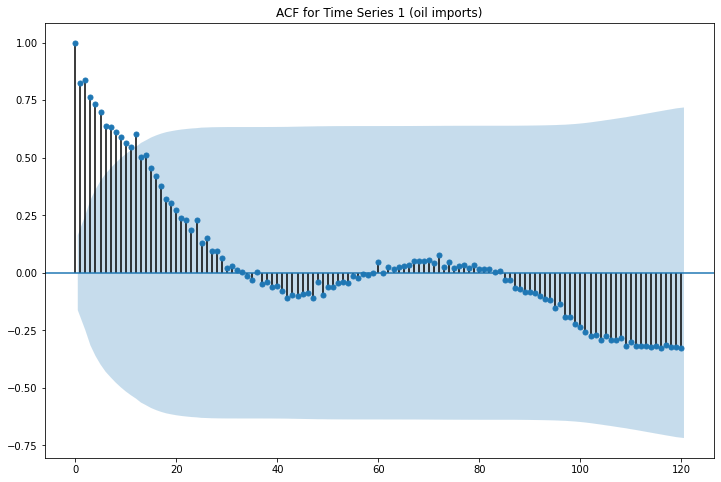

Значения автокорреляционной функции(30 лагов): 

 [1.         0.82462402 0.83582701 0.76599451 0.73297481 0.69874399
 0.63619565 0.63565252 0.61185472 0.5913249  0.5657705  0.5452244
 0.60320736 0.50110538 0.51328764 0.45473588 0.42005689 0.37897174
 0.31976601 0.30251822 0.27064775 0.23822346 0.22736185 0.18494991
 0.23082591 0.12893478 0.14995548 0.09561829 0.09340694 0.06286897
 0.02249541]


In [12]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

ac = acf(ts1['oil_imports'], nlags=30)

plt.rc("figure", figsize=(12,8))
plt.figure(figsize=(12,8))
plot_acf(ts1['oil_imports'], lags = 120, title='ACF for Time Series 1 (oil imports)')
plt.show()

print('Значения автокорреляционной функции(30 лагов):', '\n\n', ac)

Здесь нет ярко выраженной сезонности. Автокорреляция высокая для наблюдений примерно для первых 10 лагов. Все последующие значения автокорреляции попадают в доверительный интервал - то есть незначимо отличаются от 0.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


<Figure size 864x576 with 0 Axes>

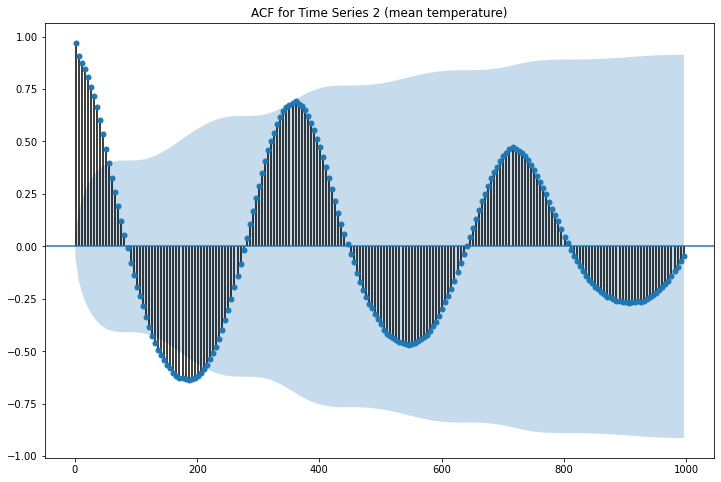

Значения автокорреляционной функции(30 лагов): 

 [1.         0.9711027  0.95095435 0.93435913 0.92457295 0.91551781
 0.90737097 0.89843343 0.89046222 0.88351839 0.87855285 0.87618765
 0.87108249 0.86575916 0.85981725 0.85384141 0.84625367 0.83890942
 0.83112316 0.82443026 0.8159426  0.80555558 0.79472453 0.78396174
 0.77645828 0.76750406 0.75910245 0.74987832 0.74150154 0.7333316
 0.72481656]


In [13]:
ac = acf(ts2['meantemp'], nlags=30)
plt.rc("figure", figsize=(12,8))
plt.figure(figsize=(12,8))
plot_acf(ts2['meantemp'], lags = range(1,1000,5), title='ACF for Time Series 2 (mean temperature)')
plt.show()

print('Значения автокорреляционной функции(30 лагов):', '\n\n', ac)

Здесь очень хорошо видна сезонность - как на графике временного ряда, так и на графике ACF. Причем мы можем отметить как высокие положительные значения автокорреляции, так и высокие отрицательные. Это связано с тем, что мы исследуем значения температуры воздуха. Как правило, значения в разные сезоны года сильно отличаются - отсюда отрицательная автокорреляция (типа лето-зима). При этом для летних температур в разные годы данные будут сильно коррелировать. 

+Получился красивый графичек :)

Длина сезонной составляющей - 365.

**Визуализация сезонности для TS2**

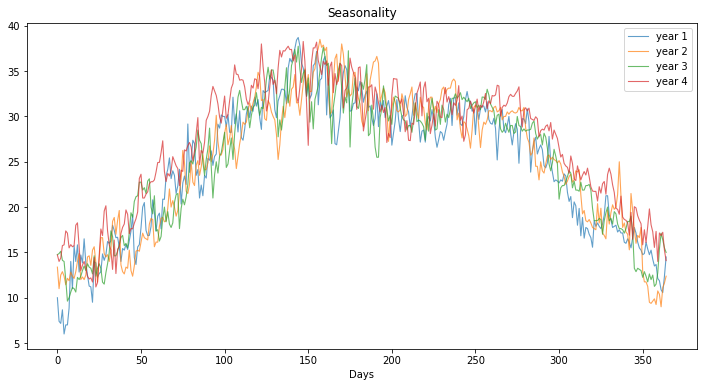

In [14]:
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(np.arange(365), ts2.iloc[i*365 : (i+1)*365, 1], alpha=0.7, linewidth='1.1', label = 'year '+str(i+1))

plt.title('Seasonality')    
plt.legend()
plt.xlabel('Days')
plt.show()

Накладываются! Еще одно подтверждение, что в данных очень сильная сезонность.

## Задание 3. Предсказание месячного временного ряда (4 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной ряд несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.

### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

MAE = 50757.8275862069


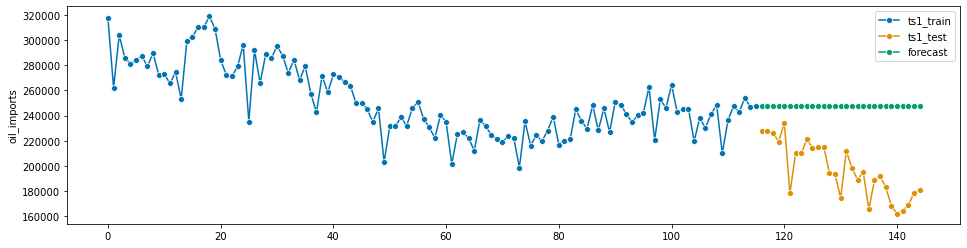

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import MeanAbsoluteError

fh = np.arange(len(ts1_test)) + 1
mae = MeanAbsoluteError()

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(ts1_train['oil_imports'])
y_forecast = forecaster.predict(fh)

plot_series(ts1_train['oil_imports'], ts1_test['oil_imports'], y_forecast, labels=["ts1_train", "ts1_test", "forecast"])
print('MAE =', mae(y_forecast, ts1_test['oil_imports']))

MAE = 41728.44827586207


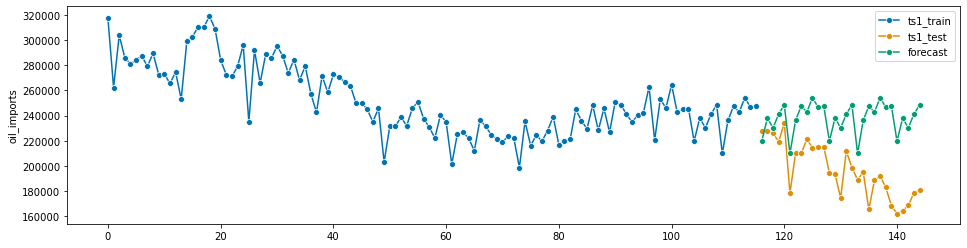

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(ts1_train['oil_imports'])
y_forecast = forecaster.predict(fh)

plot_series(ts1_train['oil_imports'], ts1_test['oil_imports'], y_forecast, labels=["ts1_train", "ts1_test", "forecast"])
print('MAE =', mae(y_forecast, ts1_test['oil_imports']))

Я подумала, что поскольку ярко выраженной сезонности в TS1 не наблюдается, можно подбирать разные параметры sp (сезонной составляющей). Тогда предсказания будут повторять разные кусочки из трейна разной длины, и, возможно, большая длина сезонности будет лучше подходить для наблюдений в тесте. Ну вот, например, в модели выше взяла сезонность=12, в модели ниже сезонность=60 (5 лет). По значению MAE можно сказать, что модель с сезонностью 60 месяцев дает более "точные" предсказания. Хотя, конечно, такого могло и не быть, но у нас это получилось, потому что данные так устроены.

MAE = 28900.793103448275


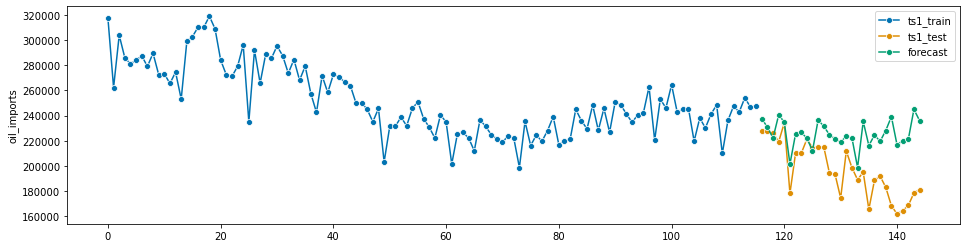

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp=60)
forecaster.fit(ts1_train['oil_imports'])
y_forecast = forecaster.predict(fh)

plot_series(ts1_train['oil_imports'], ts1_test['oil_imports'], y_forecast, labels=["ts1_train", "ts1_test", "forecast"])
print('MAE =', mae(y_forecast, ts1_test['oil_imports']))

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

MAE= 41661.40440513184


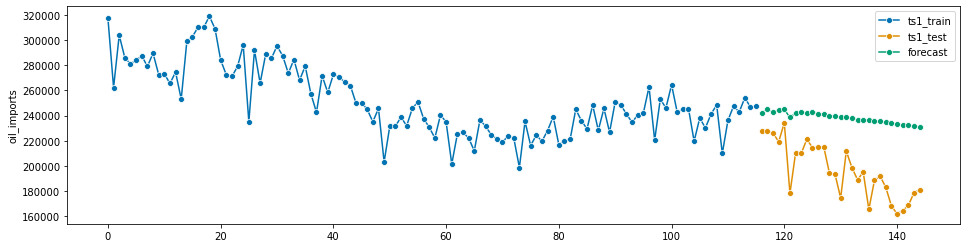

In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

forecaster = ARIMA(order=(1, 1, 1),
                   seasonal_order=(1, 0, 0, 12))
forecaster.fit(ts1_train['oil_imports'])
y_forecast = forecaster.predict(fh)

plot_series(ts1_train['oil_imports'], ts1_test['oil_imports'], y_forecast, labels=["ts1_train", "ts1_test", "forecast"])
print('MAE=', mae(y_forecast, ts1_test['oil_imports']))

MAE= 49108.54271914355


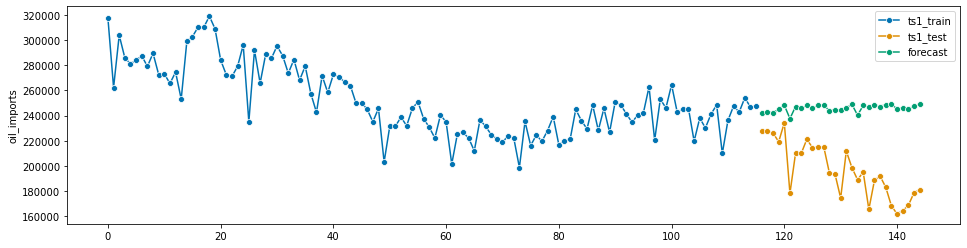

In [ ]:
forecaster = AutoARIMA(start_p=1, start_q=1, sp=12)
forecaster.fit(ts1_train['oil_imports'])
y_forecast = forecaster.predict(fh)

plot_series(ts1_train['oil_imports'], ts1_test['oil_imports'], y_forecast, labels=["ts1_train", "ts1_test", "forecast"])
print('MAE=', mae(y_forecast, ts1_test['oil_imports']))

Модель autoARIMA получилась хуже. Думаю это связано с тем, что она подбирает лучшую модель на основе информационных критериев, которые штрафуют за количество параметров в модели. Ну мб еще дело в гиперпараметрах самой модели. Anyway, ARIMA, как видим на первом графике, увидела в данных тренд и это уже хорошо. Хотя все еще модели предсказывают достаточно плохо из-за того, что невозможно догататься что после последнего в трейне наблюдения график будет убывать сильнее. Ну, думаю, that's ok, таковы данные))

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [ ]:
#!pip install orbit-ml

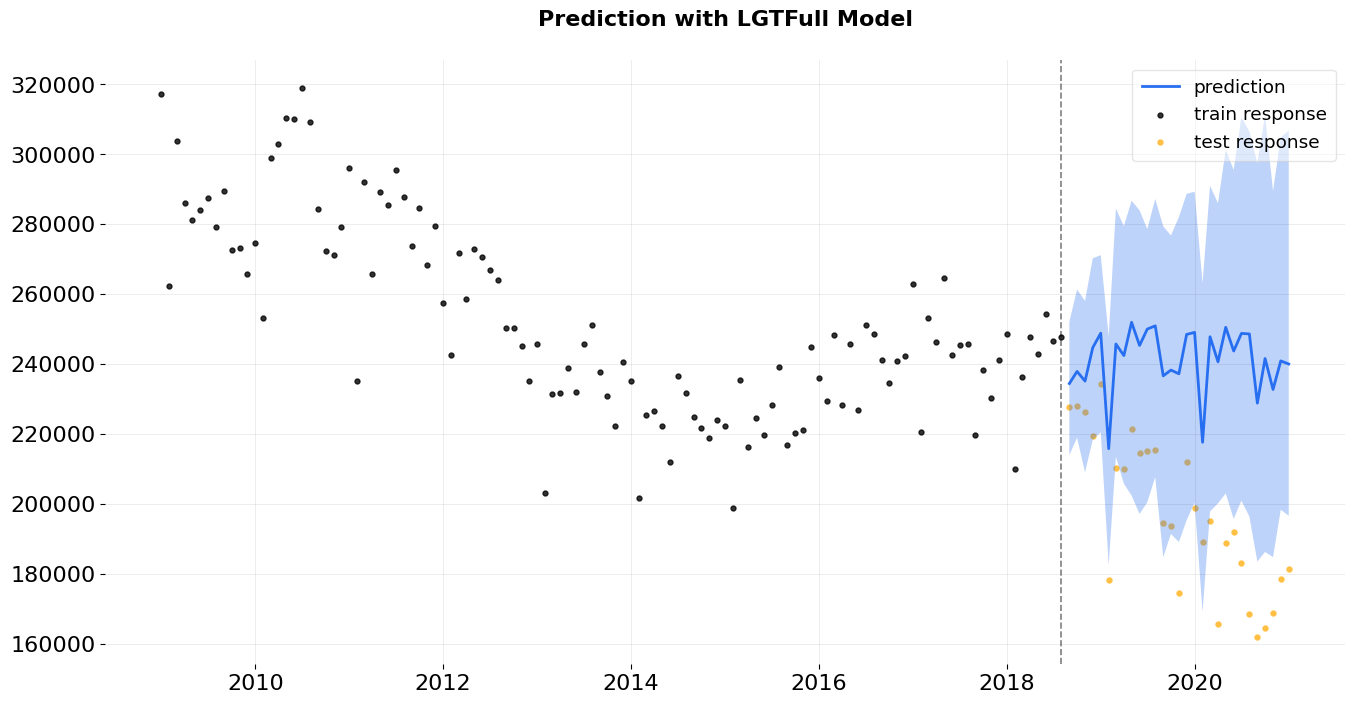

MAE= 44240.7572044455


In [45]:
import orbit
from orbit.models import LGT
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data

from sklearn.metrics import mean_absolute_error as MAE

lgt = LGT(
    response_col='oil_imports',
    date_col='date',
    seasonality=12,
    seed=420)
lgt.fit(df=ts1_train)
y_forecast = lgt.predict(df=ts1_test)

_ = plot_predicted_data(training_actual_df=ts1_train, predicted_df=y_forecast,
                    date_col=lgt.date_col, actual_col=lgt.response_col,
                    test_actual_df=ts1_test, title='Prediction with LGTFull Model')
print('MAE=', MAE(y_forecast['prediction'], ts1_test['oil_imports']))                    

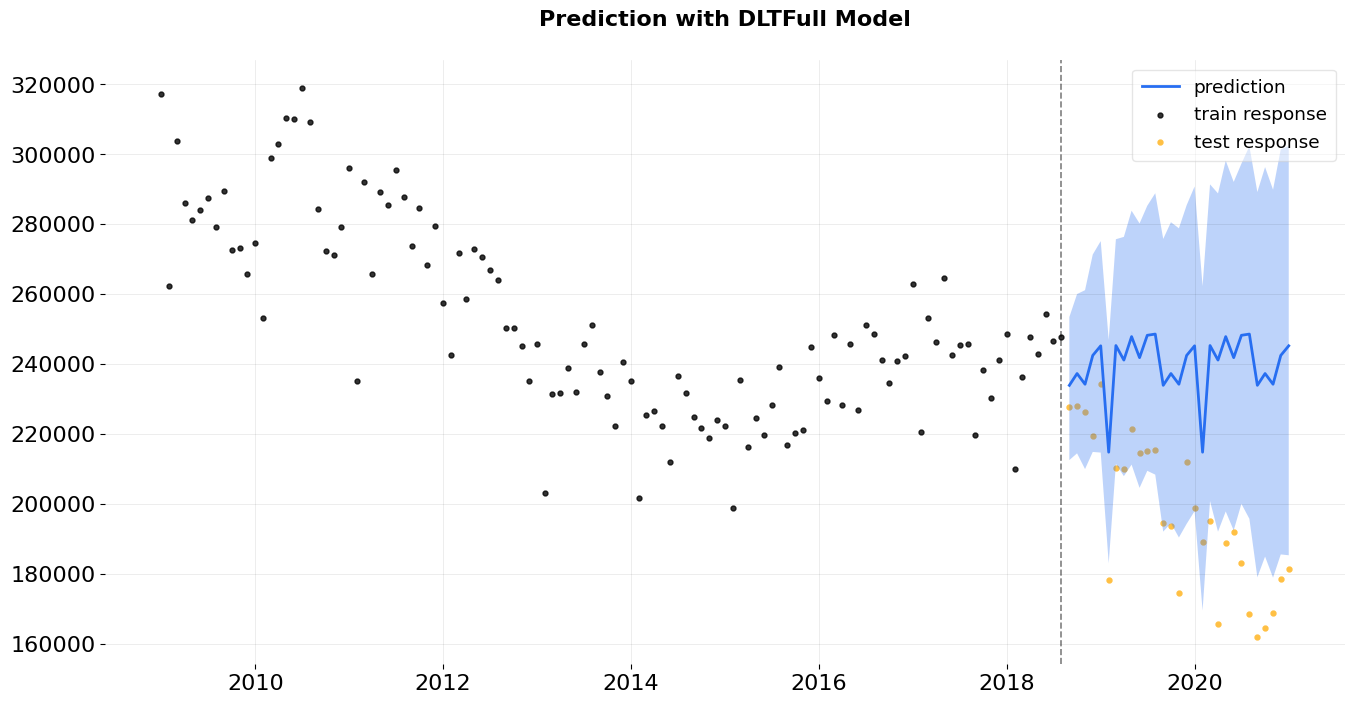

MAE= 42869.70459781109


In [46]:
dlt = DLT(
    response_col='oil_imports',
    date_col='date',
    seasonality=12,
    estimator='stan-map',
    seed=420,
    global_trend_option='loglinear',
    n_bootstrap_draws=1000)

dlt.fit(df=ts1_train)
y_forecast = dlt.predict(df=ts1_test)

_ = plot_predicted_data(training_actual_df=ts1_train, predicted_df=y_forecast,
                    date_col=dlt.date_col, actual_col=dlt.response_col,
                    test_actual_df=ts1_test, title='Prediction with DLTFull Model')
print('MAE=', MAE(y_forecast['prediction'], ts1_test['oil_imports']))  

DLT оказалась лучше.

### ETS (1 балл).

Обучите из библиотеки `sktime` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

C:\miniconsa\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


MAE= 37488.205023972754


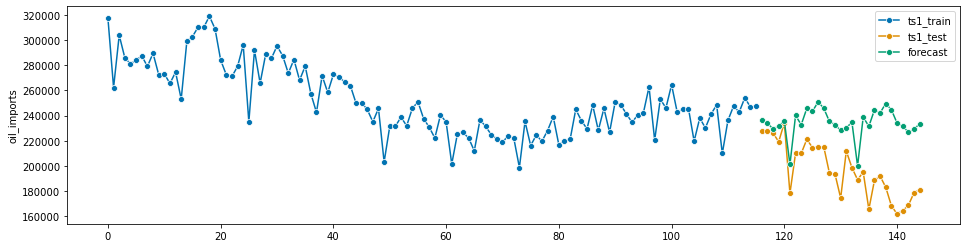

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

mae = MeanAbsoluteError()
forecaster = ExponentialSmoothing(trend='add', seasonal='add', sp=12)
forecaster.fit(ts1_train['oil_imports'])
y_forecast = forecaster.predict(fh)

plot_series(ts1_train['oil_imports'], ts1_test['oil_imports'], y_forecast, labels=["ts1_train", "ts1_test", "forecast"])
print('MAE=', mae(y_forecast, ts1_test['oil_imports']))

MAE= 39114.34951381183


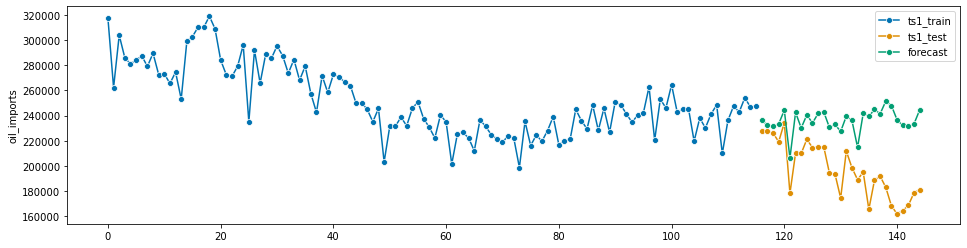

In [ ]:
forecaster = AutoETS(sp=24, auto=True)
forecaster.fit(ts1_train['oil_imports'])
y_forecast = forecaster.predict(fh)

plot_series(ts1_train['oil_imports'], ts1_test['oil_imports'], y_forecast, labels=["ts1_train", "ts1_test", "forecast"])
print('MAE=', mae(y_forecast, ts1_test['oil_imports']))

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

Тут меня посетило вдохновение запустить на этих данных тета-модель, потому что на лекции было сказано, что она **очень крута**. 

C:\miniconsa\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


MAE= 35439.16776131908


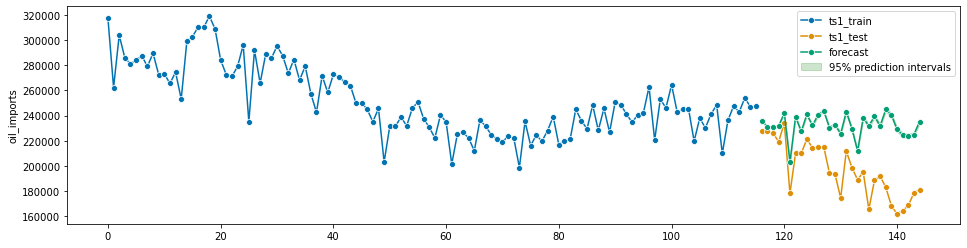

In [ ]:
from sktime.forecasting.theta import ThetaForecaster

forecaster = ThetaForecaster(sp=24)
forecaster.fit(ts1_train['oil_imports'])

y_forecast = forecaster.predict(fh)
pred_ints = forecaster.predict_interval(fh, ts1_train['oil_imports'], coverage=0.05)

fig, ax = plot_series(ts1_train['oil_imports'], ts1_test['oil_imports'], y_forecast, labels=["ts1_train", "ts1_test", "forecast"])
ax.fill_between(ts1_test['date'].index, pred_ints["Coverage"][0.05]["lower"], pred_ints["Coverage"][0.05]["upper"], alpha=0.2, color="green", label=f"{95}% prediction intervals")
plt.legend()
print('MAE=', mae(y_forecast, ts1_test['oil_imports']))

Ну вот да. Как раз по значению MAE видим, что оно наименьшее из всех вышеперечисленных моделей. (Кроме наивного предсказания с параметром sp=60, но мы его не будем рассматривать, потому что он совсем не умный и просто "угадал значения", а эти модели уже немного более осмысленные). И даже кажется, что эта модель +- понимает закономерности в данных.

На графике выше есть доверительные интервалы, но их очень слабо видно из-за того, что среднеквадратические наблюдения очень маленькие по сравнению с масштабом значений ряда. Поэтому ниже я нарисовала этот же график, но на котором лучше видны предсказания с доверительными интервалами.

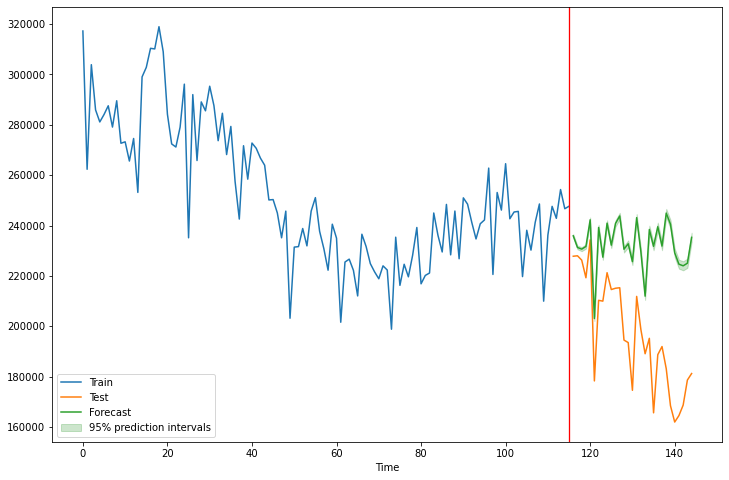

In [ ]:
fig, ax = plt.subplots()

ax.plot(ts1_train['date'].index, ts1_train['oil_imports'], label = 'Train')
ax.plot(ts1_test['date'].index, ts1_test['oil_imports'], label = 'Test')
ax.plot(ts1_test['date'].index, y_forecast, label = 'Forecast')
plt.axvline(x=breakpoint_ts1-1, linestyle='-', color='red',  linewidth=1.3)

ax.fill_between(ts1_test['date'].index, pred_ints["Coverage"][0.05]["lower"], pred_ints["Coverage"][0.05]["upper"],color="green", label=f"95% prediction intervals", alpha=0.2)
plt.legend()
plt.xlabel('Time')
plt.show()

И вот предсказания + наблюдаемые значения из тестовой выборки без трейна.

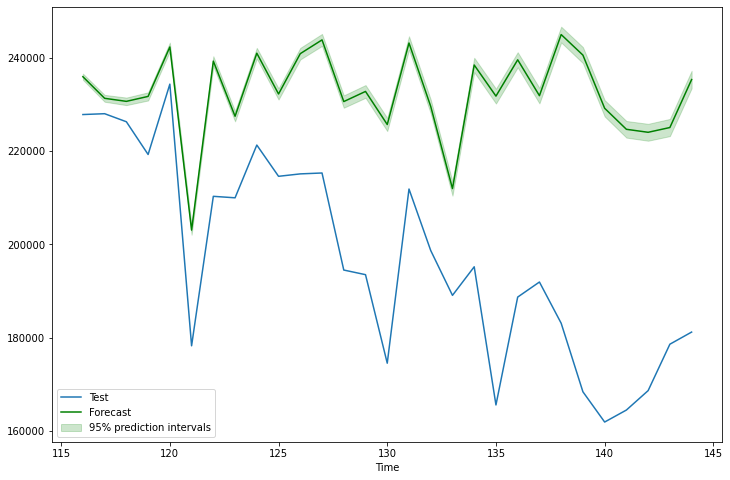

In [ ]:
fig, ax = plt.subplots()

ax.plot(ts1_test['date'].index, ts1_test['oil_imports'], label = 'Test')
ax.plot(ts1_test['date'].index, y_forecast, label = 'Forecast', color='green')

ax.fill_between(ts1_test['date'].index, pred_ints["Coverage"][0.05]["lower"], pred_ints["Coverage"][0.05]["upper"],color="green", label=f"95% prediction intervals", alpha=0.2)
plt.legend()
plt.xlabel('Time')
plt.show()

## Задание 4. Предсказание дневного временного ряда (3 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

MAE = 12.557868208515298


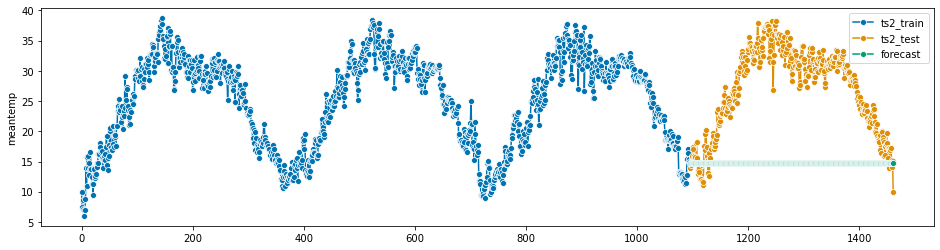

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

fh = np.arange(len(ts2_test)) + 1
mae = MeanAbsoluteError()

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(ts2_train['meantemp'])
y_forecast = forecaster.predict(fh)

plot_series(ts2_train['meantemp'], ts2_test['meantemp'], y_forecast, labels=["ts2_train", "ts2_test", "forecast"])
print('MAE =', mae(y_forecast, ts2_test['meantemp']))

MAE = 2.8429880783960444


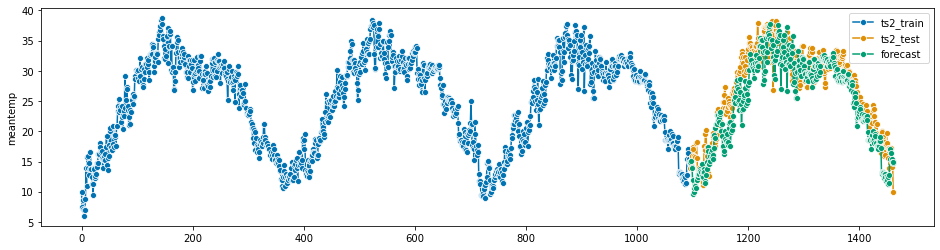

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp=365)
forecaster.fit(ts2_train['meantemp'])
y_forecast = forecaster.predict(fh)

plot_series(ts2_train['meantemp'], ts2_test['meantemp'], y_forecast, labels=["ts2_train", "ts2_test", "forecast"])
print('MAE =', mae(y_forecast, ts2_test['meantemp']))

Без сезонности мы для всего ряда (тест) предсказываем значение температуры 31 декабря, естественно это получается очень неточно и значение MAE относительно велико. Но зато, когда добавляем сезонность 365 дней, предсказания получаются хорошими. Даже для Naive Forecaster.

### KTR из orbit (1 балл).



In [ ]:
#!pip install pystan

INFO:root:Guessed max_plate_nesting = 1


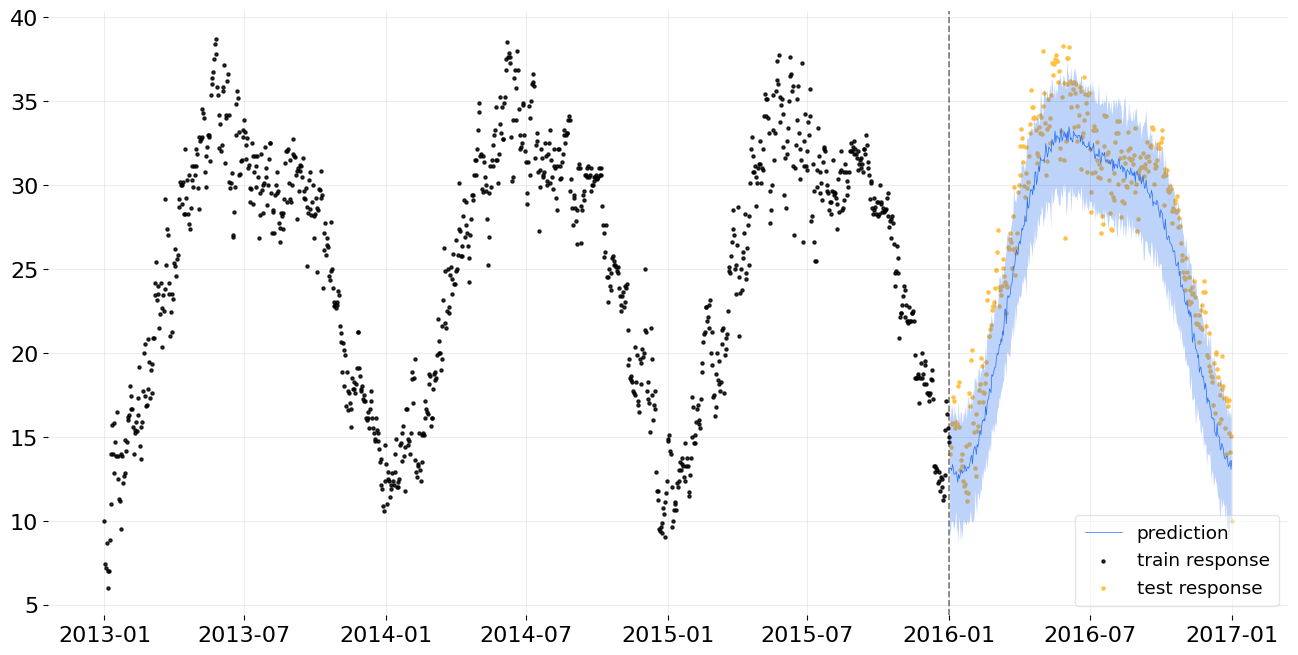

MAE= 2.5603234298708664


In [47]:
#from orbit.models.ktrlite import KTRLiteMAP
from orbit.models import KTR

ktr = KTR(
    response_col='meantemp',
    date_col='date',
    seasonality=365,
    seed=420)
ktr.fit(ts2_train)
y_forecast = ktr.predict(df=ts2_test)

_ = plot_predicted_data(training_actual_df=ts2_train, predicted_df=y_forecast,
                        date_col=ktr.date_col, actual_col=ktr.response_col,
                        test_actual_df=ts2_test, markersize=20, lw=.5)

print('MAE=', MAE(y_forecast['prediction'], ts2_test['meantemp']))   

### Phophet (1 балл).



In [ ]:
#!pip install prophet

Мне показалось, что Prophet достаточно удобная библиотека в плане того, что все методы требуют очень мало строчек кода)) Но зато, как я поняла, чтобы Prophet смог прочитать данные и обучить модель, ему нужно скормить датафрейм, оформленный определенным образом. Должны быть колонки ds - переменная времени и y - сам временной ряд. Я сделала датасет в отдельной переменной, чтобы не потерять изначальный и использовать его дальше в следующем задании.

In [35]:
df_train = ts2_train.rename(columns={'date':'ds', 'meantemp':'y'})
df_test = ts2_test.rename(columns={'date':'ds', 'meantemp':'y'})
df_train

,ds,y
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000
...,...,...
1091,2015-12-28,17.125000
1092,2015-12-29,16.375000
1093,2015-12-30,15.500000
1094,2015-12-31,15.000000


In [40]:
from prophet import Prophet

pr = Prophet()
pr.fit(df_train)

y_forecast = pr.predict(df_test)
print('MAE =', MAE(y_forecast['yhat'], ts2_test['meantemp']))


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE = 2.3896409726733068


In [44]:
# как выглядят предсказания
y_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-02,25.214959,9.100201,14.257845,25.214959,25.214959,-13.506341,-13.506341,-13.506341,-0.118553,-0.118553,-0.118553,-13.387788,-13.387788,-13.387788,0.0,0.0,0.0,11.708618
1,2016-01-03,25.215443,9.187224,14.292301,25.215443,25.215443,-13.593166,-13.593166,-13.593166,-0.223132,-0.223132,-0.223132,-13.370035,-13.370035,-13.370035,0.0,0.0,0.0,11.622277
2,2016-01-04,25.215928,9.458451,14.520094,25.215928,25.215928,-13.264351,-13.264351,-13.264351,0.068868,0.068868,0.068868,-13.333219,-13.333219,-13.333219,0.0,0.0,0.0,11.951577
3,2016-01-05,25.216413,9.391279,14.499247,25.216413,25.216413,-13.190650,-13.190650,-13.190650,0.088635,0.088635,0.088635,-13.279286,-13.279286,-13.279286,0.0,0.0,0.0,12.025763
4,2016-01-06,25.216898,9.668509,14.736825,25.216898,25.216898,-13.018400,-13.018400,-13.018400,0.191856,0.191856,0.191856,-13.210256,-13.210256,-13.210256,0.0,0.0,0.0,12.198498


Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

Prophet показал наименьшее значение MAE на тестовой выборке, поэтому берем его. Но мне не очень понравился дефолтный график ряда из этой библиотеки, поэтому я решила нарисовать свой, чтобы на нем были видны и предсказанные и наблюдаемые значения.

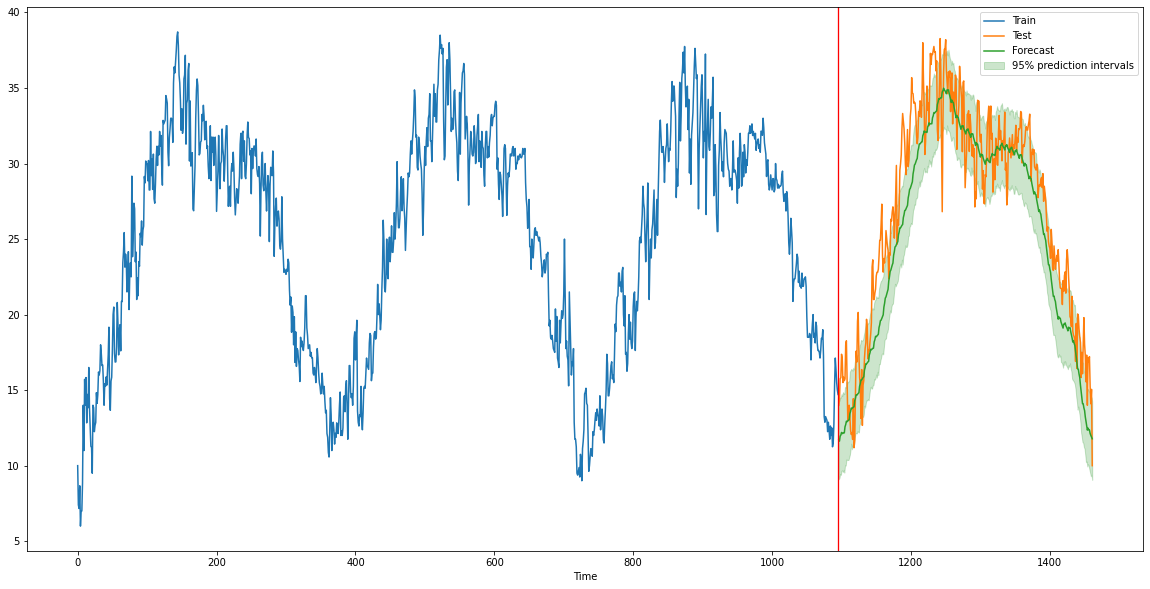

In [43]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(ts2_train['date'].index, ts2_train['meantemp'], label = 'Train')
ax.plot(ts2_test['date'].index, ts2_test['meantemp'], label = 'Test')
ax.plot(ts2_test['date'].index, y_forecast['yhat'], label = 'Forecast')
plt.axvline(x=breakpoint_ts2-1, linestyle='-', color='red',  linewidth=1.3)

ax.fill_between(ts2_test['date'].index, y_forecast['yhat_lower'], y_forecast['yhat_upper'], color="green", label=f"95% prediction intervals", alpha=0.2)
plt.legend()
plt.xlabel('Time')
plt.show()

krasivo.....

## Задание 5. Предсказание временного ряда моделями машинного обучения (1 балл).

Возьмите один из ваших рядов, сформируйте по нему матрицу объект-признак и целевой вектор.

Разбейте данные на train/test в той же пропорции, что разбивали в заданиях выше.

Обучите различные классические модели машинного обучения и оцените их качество (MAE). 

Какая из моделей справилась с задачей предсказания лучше всего?

Правильно ли я поняла задание, что здесь нужно сделать рандомное разбиение на трейн/тест? Ну иначе в чем смысл использовать модели машинного обучения, они будут явно хуже моделей для временных рядов. 

Я взяла ряд TS2, у которого четкая годовая сезонность, потому что данные прикольной структуры и мне кажется тут интересно посмотреть, как это структуру будут видеть ML модели)

Я выбрала 4 модели: 

1.   [ядровой SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py) - потому что чисто линейные модели на этих данных кажется будет использовать совсем тупо
2.   метод K ближайших соседей - потому что по соседям должно хорошо обучиться. значения температуры для соседних дней - близкие.
3. Random Forest 
4. Gradient Boosting 






In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
X = ts2['date']
y = ts2['meantemp']

# делим в той же пропорции 3:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=420)

**Kernel SVM**

[LibSVM]MAE = 6.038510031686496


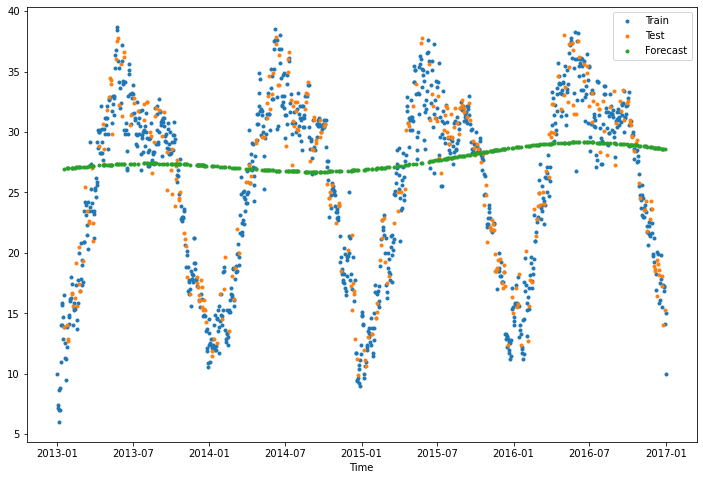

In [ ]:
reg = SVR(kernel = 'rbf', C=0.1, epsilon=0.2, verbose=True)
reg.fit(np.array(X_train).reshape(-1, 1), y_train)

y_pred = reg.predict(np.array(X_test).reshape(-1, 1))
print('MAE =', mae(y_pred, y_test))

fig, ax = plt.subplots()

ax.scatter(X_train, y_train, label = 'Train', marker='.')
ax.scatter(X_test, y_test, label = 'Test', marker='.')
ax.scatter(X_test, y_pred, label = 'Forecast', marker='.')

plt.legend()
plt.xlabel('Time')
plt.show()

ну такое. SVM, конечно, увидел, что зависимость нелинейная, но все равно слишком усреднил значения

**kNN Regression**

MAE = 1.0730385764051944


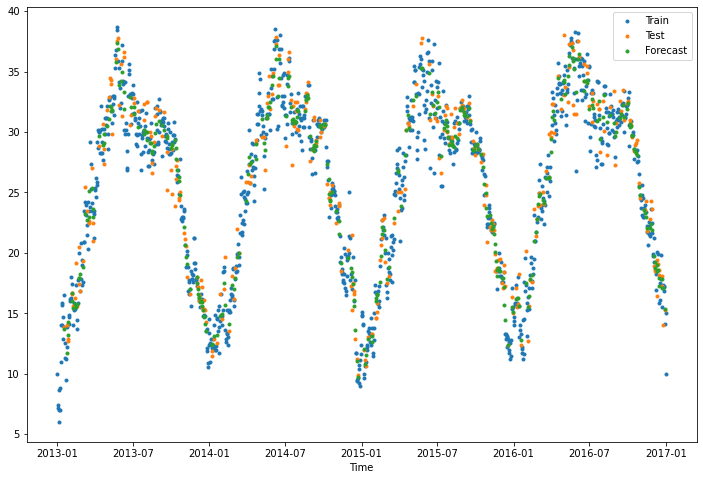

In [ ]:
reg = KNeighborsRegressor(n_neighbors=6, weights='distance')
reg.fit(np.array(X_train).reshape(-1, 1), y_train)

y_pred = reg.predict(np.array(X_test).reshape(-1, 1))
print('MAE =', mae(y_pred, y_test))

fig, ax = plt.subplots()

ax.scatter(X_train, y_train, label = 'Train', marker='.')
ax.scatter(X_test, y_test, label = 'Test', marker='.')
ax.scatter(X_test, y_pred, label = 'Forecast', marker='.')

plt.legend()
plt.xlabel('Time')
plt.show()

**Random Forest Regression**

MAE = 1.0795688369819751


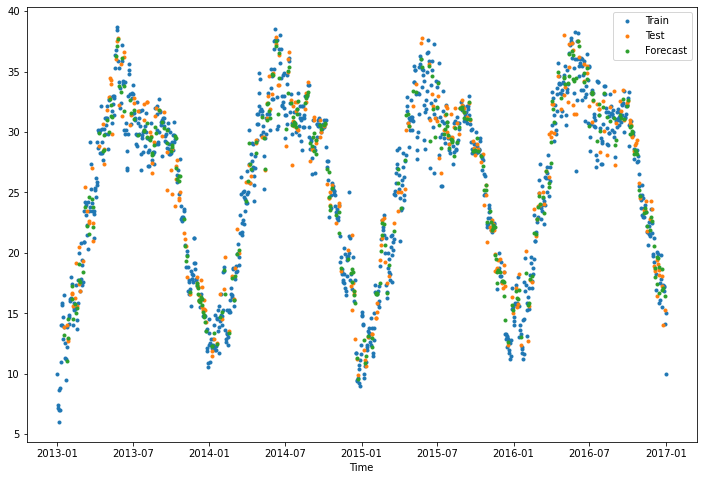

In [ ]:
reg = RandomForestRegressor(criterion='mae')
reg.fit(np.array(X_train).reshape(-1, 1), y_train)

y_pred = reg.predict(np.array(X_test).reshape(-1, 1))
print('MAE =', mae(y_pred, y_test))

fig, ax = plt.subplots()

ax.scatter(X_train, y_train, label = 'Train', marker='.')
ax.scatter(X_test, y_test, label = 'Test', marker='.')
ax.scatter(X_test, y_pred, label = 'Forecast', marker='.')

plt.legend()
plt.xlabel('Time')
plt.show()

**Gradient Boosting Regression**

C:\miniconsa\lib\site-packages\sklearn\ensemble\_gb.py:1630: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


MAE = 1.485192805392872


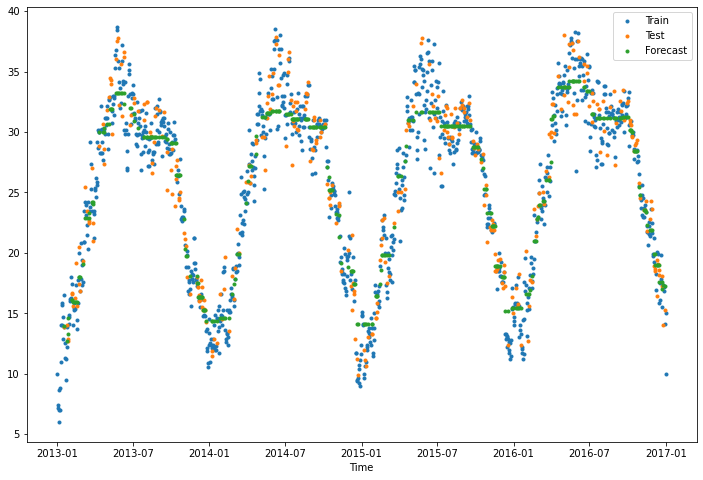

In [ ]:
reg = GradientBoostingRegressor(criterion='mae')
reg.fit(np.array(X_train.index).reshape(-1, 1), y_train)

y_pred = reg.predict(np.array(X_test.index).reshape(-1, 1))
print('MAE =', mae(y_pred, y_test))

fig, ax = plt.subplots()

ax.scatter(X_train, y_train, label = 'Train', marker='.')
ax.scatter(X_test, y_test, label = 'Test', marker='.')
ax.scatter(X_test, y_pred, label = 'Forecast', marker='.')

plt.legend()
plt.xlabel('Time')
plt.show()

Вывод: лучше всех справилась регрессия на KNN!
Значение MAE минимально среди четырех моделей. На графике тоже видим, что она улавливает зависимость между данными лучше всех остальных.

MAE = 1,073

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытайте свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной моделью на тестовой выборке с помощью MAE. 

Комментарий: итоговый балл за домашнее задание ставится по формуле минимум(10, ваш суммарный балл за задания).

In [ ]:
# ваш код модели на STAN и её обучения здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
# нарисуйте предсказания